# Wine Quality Analysis

<img src="https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1133888244%2F0x0.jpg%3Ffit%3Dscale" width="600px" />

This notebook analyse a database of **red** and **white** variants of the Portuguese "Vinho Verde" wine based on wine **physicochemical test results** and quality scores that experts assign to each wine sample.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, PolynomialFeatures, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.utils.multiclass import unique_labels

import shap

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style='whitegrid')
set_config(display='diagram')


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
shap.initjs()

In [3]:
full_df = pd.read_csv('data/winequalityN.csv')

full_df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

# Classification Objective

The most obvious classification objective for this training set is **multiclass wine quality classification**. 

The dataset is **higly imbalanced**. We have only 5 samples of exellent wines and 30 samples of the lowest quality wines. If we take into account test set split and cross-validation folds, we may have only a couple of examples during training. This means that there may be a problem of applying SMOTE and similar synthetical methods to balance datasets as they would require more samples to create clusters for samplings from.

Other possible objectives are:
- multiclass quality classification with only 3 classes: low, medium, high quality wines
- binary quality classification: good or bad quality wine
- binary wine type classification: red or white wine (which would also suffer from imbalance, but could be fixed by synthetic resampling)

In [4]:
full_df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

We will stick with **multiclass quality classification** and 3 classes: low, medium, high quality wines:

In [5]:
def impute_quality_group(quality):
    if quality <= 5:
        return 0 # low
    if quality > 5 and quality < 7:
        return 1 # average
    if quality >= 7:
        return 2 # high

full_df['quality_group'] = full_df['quality'].apply(impute_quality_group)

In [6]:
full_df['quality_group'].value_counts()

1    2836
0    2384
2    1277
Name: quality_group, dtype: int64

# Model

In [7]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='viridis', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [8]:
def score_classification_model(model, X_train, y_train):
    
    cv_scores = cross_validate(
        model, X_train, y_train, 
        scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
        cv=5,
        n_jobs=-1, verbose=0
    )

    cv_y_predicted = cross_val_predict(
        model, X_train, y_train,
        cv=5,
        n_jobs=-1
    )

    cv_f1_weighted, f1_weighted_std = cv_scores['test_f1_weighted'].mean(), cv_scores['test_f1_weighted'].std()
    cv_balanced_accuracy, balanced_accuracy_std = cv_scores['test_balanced_accuracy'].mean(), cv_scores['test_balanced_accuracy'].std()
    cv_accuracy, balanced_std = cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std()

    model.fit(X_train, y_train)

    y_train_predicted = model.predict(X_train)

    train_f1_weighted = f1_score(y_train, y_train_predicted, average='weighted')
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_predicted)

    print('[Train] F1 Weighted: %.4f' % (train_f1_weighted))
    print('[Train] Balanced Accuracy: %.4f' % (train_balanced_accuracy))
    print('Train Set Report:')
    print(classification_report(y_train, y_train_predicted, digits=3))

    print('[CV] F1 Weighted: %.4f (%.4f)' % (cv_f1_weighted, f1_weighted_std))
    print('[CV] Balanced Accuracy: %.4f (%.4f)' % (cv_balanced_accuracy, balanced_accuracy_std))
    print('[CV] Accuracy: %.4f (%.4f)' % (cv_accuracy, balanced_std))
    print('CV Report:')
    print(classification_report(y_train, cv_y_predicted, digits=3))
    
    # display confusion matrixes

    _, (ax0, ax1) = plt.subplots(1, 2)

    ax0.set_title('Train Confusion Matrix')
    plot_confusion_matrix(
        model, X_train, y_train,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax0,
        colorbar=False,
    )

    ax1.set_title('CV Confusion Matrix')
    plot_confusion_matrix_by_predictions(
        y_train, cv_y_predicted,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax1,
        colorbar=False,
    )

    return y_train_predicted, cv_y_predicted

In [9]:
# sklearn's pipeline API is limited at this point and doesn't provide a way to get columns of transformed X array
# This snippet will cover our back 

def get_columns_from_transformer(column_transformer, input_colums):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(raw_col_name)
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)

    [_, _, reminder_columns] = column_transformer.transformers_[-1]

    for col_idx in reminder_columns:
        col_name.append(input_colums[col_idx])

    return col_name

# Feature Engineering

In [10]:
for feature in ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']:
    full_df[feature] = full_df.groupby(['type'])[feature].transform(lambda x: x.fillna(x.median()))

In [11]:
def impute_sweetness(residual_sugar):
    if residual_sugar < 1:
        return 0
    if residual_sugar >= 1 and residual_sugar < 9:
        return 1
    if residual_sugar >= 9 and residual_sugar < 18:
        return 2
    if residual_sugar >= 18 and residual_sugar < 50:
        return 3
    if residual_sugar >= 50 and residual_sugar < 120:
        return 4
    if residual_sugar >= 120:
        return 5

full_df['sweetness'] = full_df['residual sugar'].apply(impute_sweetness)

In [12]:
full_df['alcohol_amount'] = 8 * full_df['alcohol'] / 1000 # g/L
full_df['pH_amount'] = 1 + 10 ** (full_df['pH'] - 1.8)

full_df['molecular_sulfur_dioxid'] = full_df['free sulfur dioxide'] / full_df['pH_amount']
full_df['free_total_so2_rate'] = full_df['free sulfur dioxide'] / full_df['total sulfur dioxide']
full_df['bound_sulfur_dioxid'] = full_df['total sulfur dioxide'] - full_df['free sulfur dioxide']
full_df['sugar_acidity_ratio'] = full_df['residual sugar'] / full_df['fixed acidity']

full_df['sugar_alcohol_ratio'] = full_df['residual sugar'] / full_df['alcohol_amount']
full_df['free_so2_alcohol_ratio'] = (full_df['free sulfur dioxide']) / (full_df['alcohol_amount'] * 1000)
full_df['pH_alcohol_ratio'] = full_df['pH_amount'] / full_df['alcohol_amount']
full_df['sulphates_alcohol_ratio'] = (full_df['sulphates']) / (full_df['alcohol_amount'])

alcohol_labels = ['low', 'medium', 'high']
alcohol_bins = [0, 9.5, 11.5, 20]
full_df['alcohol_groups'] = pd.cut(full_df['alcohol'], bins=alcohol_bins, labels=alcohol_labels) 

pH_labels = ['high', 'mod high', 'medium', 'low']
pH_bins = [2.5, 3.2, 3.3, 3.4, 4.1]
full_df['pH_groups'] = pd.cut(full_df['pH'], bins=pH_bins, labels=pH_labels) 

Feature Engineering:
- `total sulfur dioxide` - doesn't improve models in a raw view
- `free_total_so2_rate` - brings 0 improvements
- `sweetness` - degrades performance of all models
- `alcohol_groups` - degrades performance of all models
- `pH_groups` - degrades performance of all models
- `sugar_acidity_ratio` improves score's std but degrades CV scores

In [13]:
model_features = [
    'alcohol_amount',
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'pH',
    'residual sugar',
    'free sulfur dioxide',
    'chlorides',
    'density',
    'sulphates',
    'bound_sulfur_dioxid',
    'molecular_sulfur_dioxid',
    'sugar_acidity_ratio',
    'sugar_alcohol_ratio',
    'free_so2_alcohol_ratio',
    'pH_alcohol_ratio',
    'sulphates_alcohol_ratio',
]

X = full_df[model_features]
y = full_df['quality_group']

white_df = full_df[full_df['type'] == 'white']
X_white = white_df[model_features]
y_white = white_df['quality_group']

red_df = full_df[full_df['type'] == 'red']
X_red = red_df[model_features]
y_red = red_df['quality_group']

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, test_idx in stratified_splitter.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

for train_idx, test_idx in stratified_splitter.split(X_white, y_white):
    X_white_train, y_white_train = X_white.iloc[train_idx], y_white.iloc[train_idx]
    X_white_test, y_white_test = X_white.iloc[test_idx], y_white.iloc[test_idx]
    white_test_idx = test_idx

for train_idx, test_idx in stratified_splitter.split(X_red, y_red):
    X_red_train, y_red_train = X_red.iloc[train_idx], y_red.iloc[train_idx]
    X_red_test, y_red_test = X_red.iloc[test_idx], y_red.iloc[test_idx]

# Data Processing

In [17]:
def get_feature_transformer():
    oneplus_transformer = FunctionTransformer(func=lambda x: 1 + x, inverse_func=lambda x: 1 - x)
    boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)

    numerical_transformer = Pipeline([
        ('positive_transforming', oneplus_transformer),
        ('boxcox_transforming', boxcox_transformer),
    ])

    return ColumnTransformer([
            ('feature_transforming', numerical_transformer, [
                'fixed acidity', 'chlorides', 'citric acid', 'volatile acidity',
                'residual sugar', 'free sulfur dioxide', 'alcohol_amount',
                'sulphates', 'pH', 'sugar_acidity_ratio', 'sugar_alcohol_ratio',
                'free_so2_alcohol_ratio', 'pH_alcohol_ratio', 'sulphates_alcohol_ratio'
            ]),
        ],
        remainder='passthrough'
    )

# Polynomial Regression

In [18]:
logistic_classifier = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

polynomial_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('polynomial_features', PolynomialFeatures()),
    ('scaling', StandardScaler()),
    ('quality_classification', logistic_classifier),
])

polynomial_pipeline

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function get_feature_transformer.<locals>.<lambda> at 0x13b274ee0>,
                                                                                       inverse_func=<function get_feature_transformer.<locals>.<lambda> at 0x139c1ac10>)),
                                                                  ('boxcox_transforming...
                                                   'free sulfur dioxide',
                                                   'alcohol_amount',
                                                   'sulphates', 'pH',
                                                   'sugar_acidity_ratio',
                                                   'sugar_alcohol_ratio',
                                                   'free_so2_alcohol_ratio',
                                                   'pH_alcohol_ratio',
                                                   'sulphates_alcohol_ratio'])])),
                ('polynomial_features', PolynomialFeatures()),
                ('scaling', StandardScaler()),
                ('quality_classification',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='newton-cg'))])

[Train] F1 Weighted: 0.5819
[Train] Balanced Accuracy: 0.6290
Train Set Report:
              precision    recall  f1-score   support

           0      0.647     0.739     0.690      1312
           1      0.630     0.411     0.498      1758
           2      0.491     0.737     0.589       848

    accuracy                          0.591      3918
   macro avg      0.589     0.629     0.592      3918
weighted avg      0.606     0.591     0.582      3918

[CV] F1 Weighted: 0.5544 (0.0215)
[CV] Balanced Accuracy: 0.6003 (0.0171)
[CV] Accuracy: 0.5643 (0.0192)
CV Report:
              precision    recall  f1-score   support

           0      0.628     0.714     0.669      1312
           1      0.588     0.387     0.467      1758
           2      0.468     0.699     0.560       848

    accuracy                          0.564      3918
   macro avg      0.561     0.600     0.565      3918
weighted avg      0.575     0.564     0.555      3918



(array([1, 2, 1, ..., 0, 2, 2]), array([1, 2, 1, ..., 0, 2, 1]))

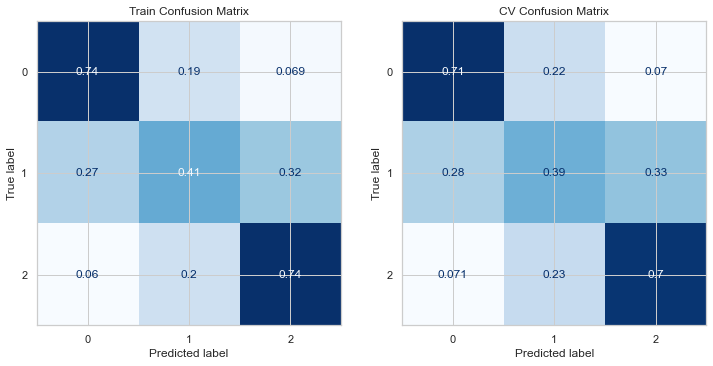

In [19]:
score_classification_model(polynomial_pipeline, X_white_train, y_white_train)

### Hyperparam Tuning

In [17]:
parameters = [
    {
        'quality_classification__solver': ['newton-cg'], # lbfgs, liblinear, 'lbfgs', 'sag', 'saga',
        'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
        'quality_classification__C': [1.0], # 1.0
        'quality_classification__l1_ratio': [1.0, 0.9],
        'quality_classification__max_iter': [100, 200],
        'quality_classification__class_weight': ['balanced'],
        'polynomial_features__degree': [2],
    },
]

param_searcher = GridSearchCV(
   estimator=polynomial_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

## RandomForest

In [20]:
rf_classifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=179,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

rf_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('quality_classification', rf_classifier),
])

## F1 Weighted: 0.6949 (0.0167), Balanced Accuracy: 0.6948 (0.0211)
# criterion='entropy',
# n_estimators=179,
# min_samples_split=5,
# min_samples_leaf=4,
# max_features='sqrt',
# class_weight='balanced'

In [21]:
rf_red_classifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=80,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

rf_red_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('quality_classification', rf_red_classifier),
])


In [22]:
rf_white_classifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

rf_white_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('quality_classification', rf_white_classifier),
])

[Train] F1 Weighted: 0.9604
[Train] Balanced Accuracy: 0.9644
Train Set Report:
              precision    recall  f1-score   support

           0      0.954     0.960     0.957      1312
           1      0.973     0.949     0.961      1758
           2      0.947     0.983     0.965       848

    accuracy                          0.960      3918
   macro avg      0.958     0.964     0.961      3918
weighted avg      0.961     0.960     0.960      3918

[CV] F1 Weighted: 0.6761 (0.0137)
[CV] Balanced Accuracy: 0.6792 (0.0129)
[CV] Accuracy: 0.6764 (0.0138)
CV Report:
              precision    recall  f1-score   support

           0      0.717     0.726     0.721      1312
           1      0.661     0.643     0.652      1758
           2      0.644     0.669     0.656       848

    accuracy                          0.676      3918
   macro avg      0.674     0.679     0.677      3918
weighted avg      0.676     0.676     0.676      3918



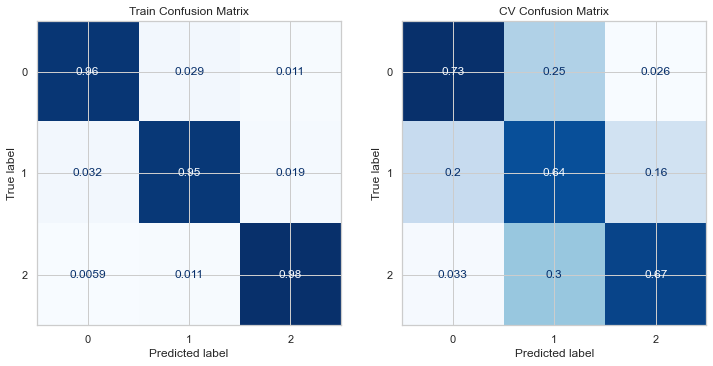

In [23]:
y_white_train_pred, y_white_cv_pred = score_classification_model(rf_white_pipeline, X_white_train, y_white_train)

[Train] F1 Weighted: 0.9977
[Train] Balanced Accuracy: 0.9983
Train Set Report:
              precision    recall  f1-score   support

           0      1.000     0.995     0.997       595
           1      0.996     1.000     0.998       510
           2      0.994     1.000     0.997       174

    accuracy                          0.998      1279
   macro avg      0.997     0.998     0.998      1279
weighted avg      0.998     0.998     0.998      1279

[CV] F1 Weighted: 0.7110 (0.0138)
[CV] Balanced Accuracy: 0.6775 (0.0290)
[CV] Accuracy: 0.7123 (0.0135)
CV Report:
              precision    recall  f1-score   support

           0      0.783     0.800     0.791       595
           1      0.654     0.657     0.656       510
           2      0.629     0.575     0.601       174

    accuracy                          0.712      1279
   macro avg      0.689     0.677     0.683      1279
weighted avg      0.711     0.712     0.711      1279



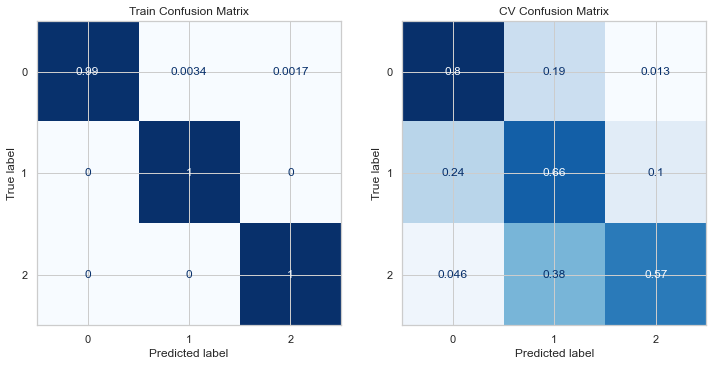

In [24]:
y_red_train_pred, y_red_cv_pred = score_classification_model(rf_red_pipeline, X_red_train, y_red_train)

### Hyperparam Tuning

In [23]:
parameters = {
    'quality_classification__n_estimators': [40, 50, 60],
    'quality_classification__criterion': ['entropy', 'gini'], #
    'quality_classification__max_features': [None, 'sqrt', 'log2', 'auto'],
    'quality_classification__max_depth': [6], # 3, 4, 5
    'quality_classification__min_samples_split': [3, 4], # 2
    'quality_classification__min_samples_leaf': [3, 4], # 2
    'quality_classification__max_samples': [None, 0.2, 0.8], # 2
    'quality_classification__class_weight': ['balanced'],
}

param_searcher = GridSearchCV(
   estimator=rf_red_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_red_train, y_red_train)
#param_searcher.best_params_, param_searcher.best_score_

# Model Inspection

In [25]:
X_train_features = get_columns_from_transformer(rf_white_pipeline.named_steps['feature_processing'], list(X_white_train.columns))

In [26]:
features_importance = sorted(zip(rf_red_pipeline.named_steps['quality_classification'].feature_importances_, X_train_features), reverse=True)

pd.DataFrame(features_importance, columns=['importance', 'feature'])

importance                  feature
0     0.228984           alcohol_amount
1     0.094848         volatile acidity
2     0.087245                sulphates
3     0.076155      bound_sulfur_dioxid
4     0.064415  sulphates_alcohol_ratio
5     0.053007                chlorides
6     0.052240              citric acid
7     0.046481      sugar_acidity_ratio
8     0.043573                  density
9     0.042232         pH_alcohol_ratio
10    0.041484  molecular_sulfur_dioxid
11    0.036980   free_so2_alcohol_ratio
12    0.035431      sugar_alcohol_ratio
13    0.034794            fixed acidity
14    0.026045                       pH
15    0.018905           residual sugar
16    0.017181      free sulfur dioxide

In [27]:
features_importance = sorted(zip(rf_white_pipeline.named_steps['quality_classification'].feature_importances_, X_train_features), reverse=True)

pd.DataFrame(features_importance, columns=['importance', 'feature'])

importance                  feature
0     0.145374           alcohol_amount
1     0.083176         volatile acidity
2     0.079248                  density
3     0.064016                chlorides
4     0.059605      bound_sulfur_dioxid
5     0.054919              citric acid
6     0.053581   free_so2_alcohol_ratio
7     0.052414      sugar_acidity_ratio
8     0.049067         pH_alcohol_ratio
9     0.048931      sugar_alcohol_ratio
10    0.048795  molecular_sulfur_dioxid
11    0.048661      free sulfur dioxide
12    0.047168  sulphates_alcohol_ratio
13    0.043476                       pH
14    0.042786            fixed acidity
15    0.041650           residual sugar
16    0.037133                sulphates

In [28]:
y_white_test_predict = rf_white_pipeline.predict(X_white_test)
y_red_test_predict = rf_red_pipeline.predict(X_red_test)

In [29]:
# Create object that can calculate shap values
X_red_test_transformed = pd.DataFrame(
    rf_red_pipeline.named_steps['feature_processing'].transform(X_red_test), 
    columns = X_train_features
)
red_explainer = shap.TreeExplainer(rf_red_classifier)

# Calculate Shap values
red_shap_values = red_explainer.shap_values(X_red_test_transformed, y_red_test)

In [30]:
# Create object that can calculate shap values
X_white_test_transformed = pd.DataFrame(
    rf_white_pipeline.named_steps['feature_processing'].transform(X_white_test), 
    columns = X_train_features
)
white_explainer = shap.TreeExplainer(rf_white_classifier)

# Calculate Shap values
white_shap_values = white_explainer.shap_values(X_white_test_transformed, y_white_test)

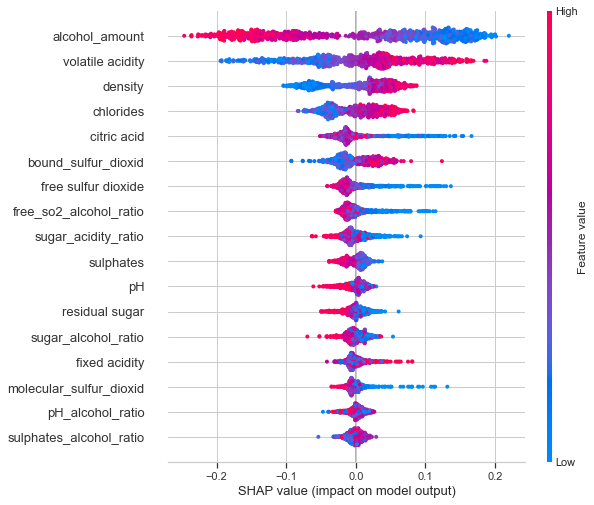

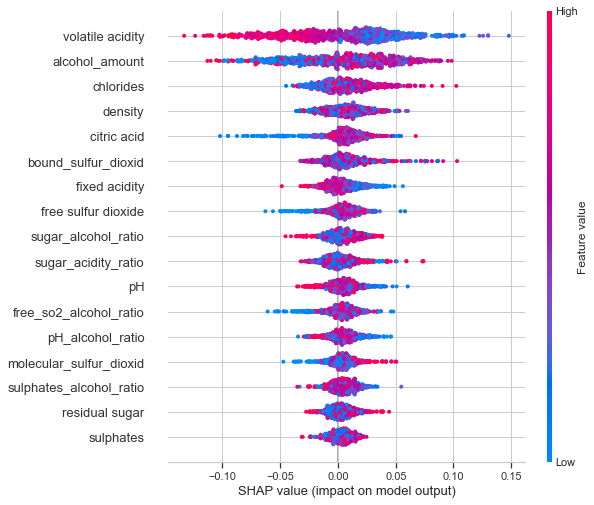

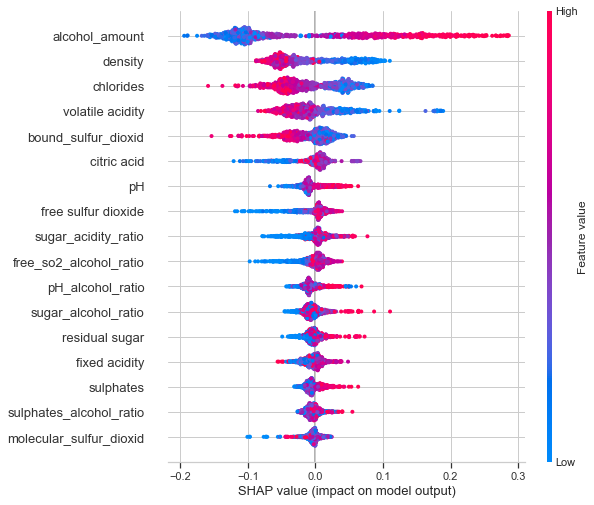

In [31]:
shap.summary_plot(white_shap_values[0], X_white_test_transformed)
shap.summary_plot(white_shap_values[1], X_white_test_transformed)
shap.summary_plot(white_shap_values[2], X_white_test_transformed)

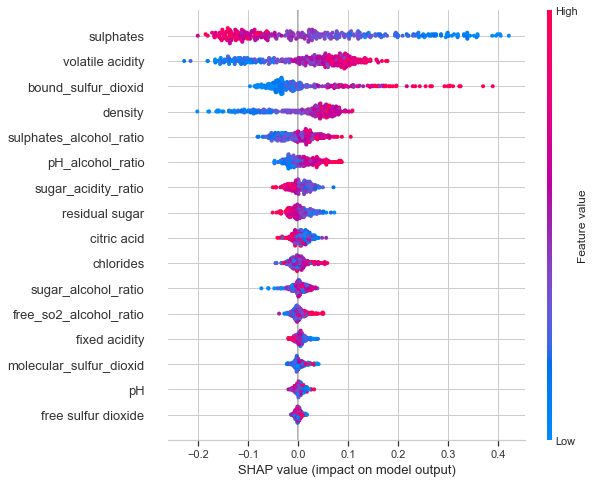

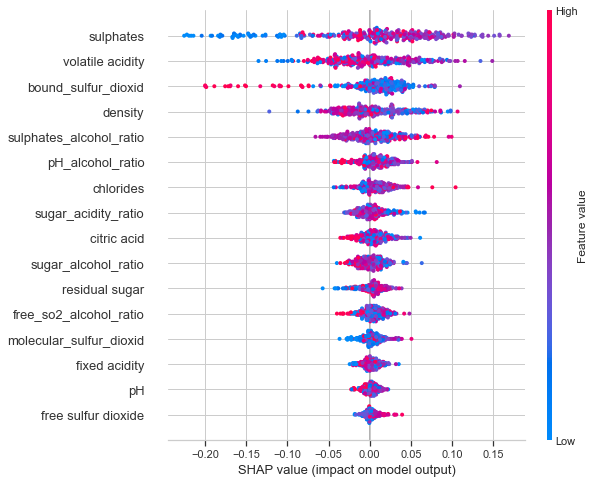

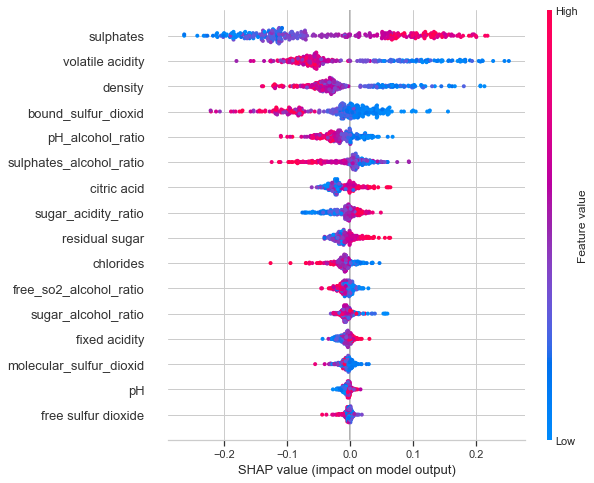

In [36]:
shap.summary_plot(red_shap_values[0], X_red_test_transformed)
shap.summary_plot(red_shap_values[1], X_red_test_transformed)
shap.summary_plot(red_shap_values[2], X_red_test_transformed)

In [37]:
confused_middle_wines = [(idx, original_idx) for idx, (original_idx, y_true, y_pred) in enumerate(zip(white_test_idx, y_white_test, y_white_test_predict)) if y_true == 1 and y_pred == 2]

confused_middle_wines

[(4, 4308),
 (6, 2862),
 (9, 3153),
 (16, 3894),
 (26, 2885),
 (69, 3532),
 (70, 4607),
 (123, 4482),
 (183, 3130),
 (185, 1289),
 (227, 4469),
 (256, 3150),
 (270, 4463),
 (274, 671),
 (282, 2406),
 (289, 4675),
 (360, 1233),
 (424, 1101),
 (426, 4534),
 (431, 4268),
 (463, 4865),
 (479, 1391),
 (484, 3825),
 (508, 4603),
 (540, 3977),
 (546, 4797),
 (602, 3284),
 (605, 2453),
 (620, 2597),
 (636, 3910),
 (637, 3214),
 (664, 741),
 (680, 3916),
 (685, 2723),
 (687, 2197),
 (695, 4361),
 (721, 2677),
 (723, 704),
 (728, 1518),
 (739, 4890),
 (746, 2369),
 (767, 494),
 (805, 4490),
 (824, 4552),
 (837, 2638),
 (843, 976),
 (866, 1818),
 (902, 3865),
 (909, 4883),
 (932, 3017),
 (951, 4313),
 (964, 2976)]

Predicts 2 class instead of 0 class:
- 191, 3079 - alcohol (9%) pushed DP toward 2 class
- 287, 3057 - model with 80% confidence predicted 2 class. Almost all features forced 2 class. 
- 521, 4507 - alcohol (9.8%) pushed DP toward 2 class
- 564, 409 - alcohol confused the model (fight with pH + density) Model made even predictions (0.36/0.36) for both classes
- 750, 3648 - alcohol (11%) confused the model
- 769, 334 - alcohol + free SO2 confused model to reject 0 class. Chlorides pushed model to pick 2 class
- 774, 2570 - alcohol confused model (11.4%)

Predicts 2 class instead of 1 class:
- 4, 4308 - pH confused model to reject 1 class. Alcohol (11.4%) pushed model to give more confidence to class 2
- 6, 2862 - pH (3.34) confused model to reject 1 class. Alcohol (11.4%) pushed model to give more confidence to class 2
- 9, 3153 - density + fixed acidity (5.8) confused model to reject 1 class. Alcohol (12.3%) and density (0.98994) pushed model to give more confidence to class 2
- 26, 2885 - Alcohol (12.8%) pushed model to give more confidence to class 2

In [38]:
MISCLASS_ID = 26

In [39]:
X_white_test.iloc[MISCLASS_ID]

fixed acidity                6.900000
volatile acidity             0.400000
citric acid                  0.300000
pH                           3.150000
residual sugar              10.600000
free sulfur dioxide         24.000000
chlorides                    0.033000
density                      0.992650
sulphates                    0.450000
bound_sulfur_dioxid         63.000000
molecular_sulfur_dioxid      1.026202
sugar_acidity_ratio          1.536232
sugar_alcohol_ratio        103.515625
free_so2_alcohol_ratio       0.234375
pH_alcohol_ratio           228.390736
sulphates_alcohol_ratio      4.394531
Name: 2885, dtype: float64

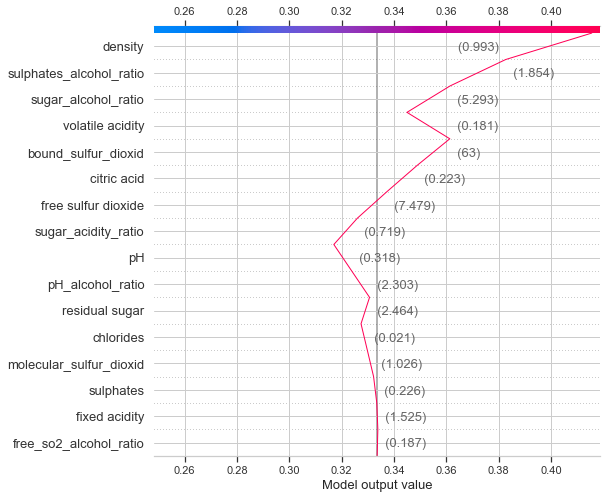

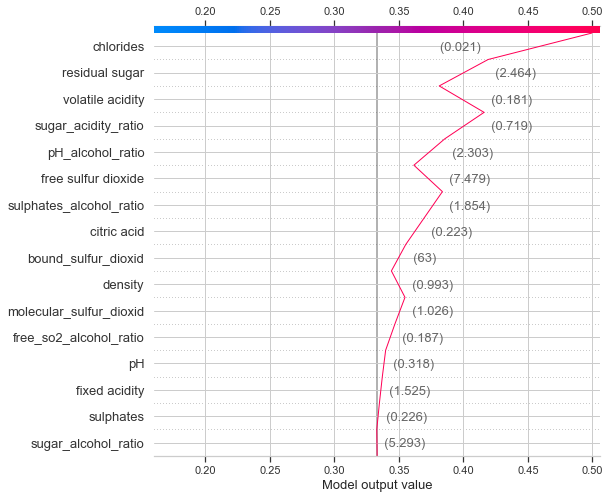

In [40]:
shap.decision_plot(white_explainer.expected_value[1], white_shap_values[1][MISCLASS_ID, :], X_white_test_transformed.iloc[MISCLASS_ID, :])
shap.decision_plot(white_explainer.expected_value[2], white_shap_values[2][MISCLASS_ID, :], X_white_test_transformed.iloc[MISCLASS_ID, :])

# Generalization

In [41]:
def score_model_generalization(model, X_test, y_test):
    y_test_predicted = model.predict(X_test)

    test_f1_weighted = f1_score(y_test, y_test_predicted, average='weighted')
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_predicted)

    print('[Test] F1 Weighted: %.4f' % (test_f1_weighted))
    print('[Test] Balanced Accuracy: %.4f' % (test_balanced_accuracy))
    print('Test Set Report:')
    print(classification_report(y_test, y_test_predicted, digits=3))

    plot_confusion_matrix_by_predictions(
        y_test, y_test_predicted,
        cmap=plt.cm.Greens,
        normalize='true',
        colorbar=False,
    )

## Polynomial Regression

[Test] F1 Weighted: 0.5236
[Test] Balanced Accuracy: 0.5745
Test Set Report:
              precision    recall  f1-score   support

           0      0.556     0.782     0.650       477
           1      0.581     0.309     0.403       567
           2      0.494     0.633     0.555       256

    accuracy                          0.546      1300
   macro avg      0.544     0.574     0.536      1300
weighted avg      0.555     0.546     0.524      1300



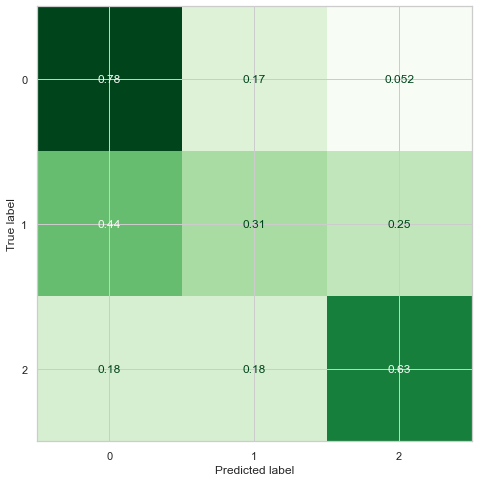

In [43]:
score_model_generalization(polynomial_pipeline, X_test, y_test)

## Random Forest

[Test] F1 Weighted: 0.7078
[Test] Balanced Accuracy: 0.7119
Test Set Report:
              precision    recall  f1-score   support

           0      0.726     0.753     0.740       328
           1      0.694     0.675     0.684       440
           2      0.708     0.708     0.708       212

    accuracy                          0.708       980
   macro avg      0.709     0.712     0.710       980
weighted avg      0.708     0.708     0.708       980



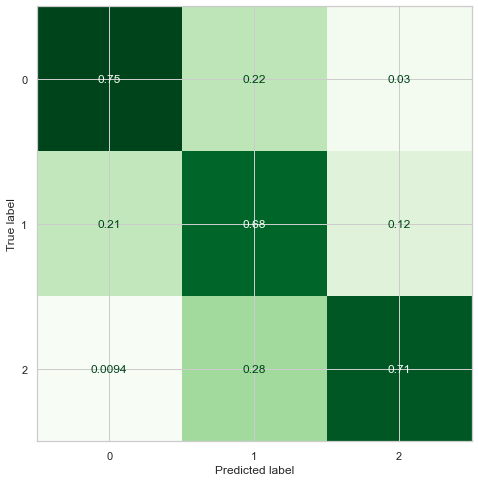

In [44]:
score_model_generalization(rf_white_pipeline, X_white_test, y_white_test)

[Test] F1 Weighted: 0.7276
[Test] Balanced Accuracy: 0.7175
Test Set Report:
              precision    recall  f1-score   support

           0      0.783     0.799     0.791       149
           1      0.667     0.656     0.661       128
           2      0.714     0.698     0.706        43

    accuracy                          0.728       320
   macro avg      0.721     0.718     0.719       320
weighted avg      0.727     0.728     0.728       320



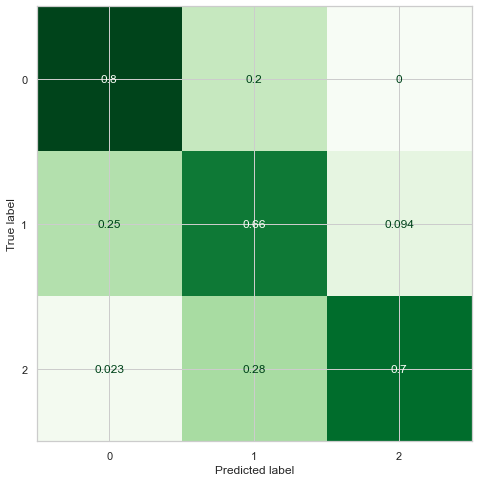

In [45]:
score_model_generalization(rf_red_pipeline, X_red_test, y_red_test)